### Code ReadME
This code is a completion for LSGD optimizer application for DIP on the task of MRI.

### Package Import

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%reload_ext autoreload
%autoreload 2
from __future__ import print_function
import sys
sys.path.append("..")
from module.spectual_norm_DIP import *

import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio
from util.measure_utils import *
from util.common_utils import *
from util.visual_utils import *
from util.gaussian_util import *
from torch.utils.tensorboard import SummaryWriter
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

### Image Import

-1 1


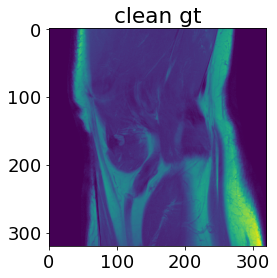

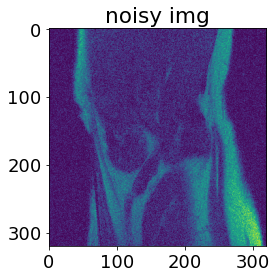

origin PSNR is:21.057153247987127


In [11]:
name = 'LSGD_DIP_denoise_image_MRI'
log_path_prefix = '../log'
img_path = '../data/MRI/test_turth0000.npy'
noisy_path = '../data/MRI/test_0.1sigma0000.npy'
save_img_path_prefix = '../output'

log_dir = os.path.join(log_path_prefix, name)
save_img_dir = os.path.join(save_img_path_prefix, name)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(save_img_dir):
    os.makedirs(save_img_dir)
writer = SummaryWriter(log_dir)
### Import data and show
img_pil = abs(np.load(img_path))
img_np = img_pil.reshape(1, img_pil.shape[0], img_pil.shape[1])
# img_pil = np_to_pil(img_np)

dtype_range = {bool: (False, True),
               np.bool_: (False, True),
               np.bool8: (False, True),
               float: (-1, 1),
               np.float_: (-1, 1),
               np.float16: (-1, 1),
               np.float32: (-1, 1),
               np.float64: (-1, 1)}
dmin, dmax = dtype_range[img_np.dtype.type]
print(dmin, dmax)

# noise level
img_noisy_pil = abs(np.load(noisy_path))
img_noisy_np  = img_noisy_pil.reshape(1, img_noisy_pil.shape[0], img_noisy_pil.shape[1])

plt.imshow(img_pil)
plt.title('clean gt')
plt.show()
plt.title('noisy img')
plt.imshow(img_noisy_pil)
plt.show()

print("origin PSNR is:{}".format(compare_psnr(img_pil, img_noisy_pil)))

### Net Prepare

In [12]:
"""y_input_torch = torch.from_numpy(img_np).type(dtype)
y_input_torch = torch.abs(y_input_torch.unsqueeze(0)).to(device)"""

INPUT = 'fourier'  # 'meshgrid', 'noise', 'fourier'
burnin_iter = 7000
MCMC_iter = 50
var = 1
input_depth = 32
net_input = get_noise(input_depth, INPUT, (img_pil.shape[1] // 32, img_pil.shape[0] // 32), var=var).type(dtype).detach()

#network parameters
ln_lambda = 1.4  #the lambda in Lipschitz normalization, which is used to control spectral bias
upsample_mode = 'bilinear'  #['deconv', 'nearest', 'bilinear', 'gaussian'], where 'gaussian' denotes our Gaussian upsampling.
pad = 'reflection'
#decoder is the used network architecture in the paper
net = decoder(num_input_channels=input_depth, num_output_channels=1, ln_lambda=ln_lambda,
              upsample_mode=upsample_mode, pad=pad, need_sigmoid=True, need_bias=True).type(dtype)

#optimization parameters
OPTIMIZER = 'adam'
num_iter = 10000
LR = 0.001
reg_noise_std = 0  #1./30, injecting noise in the input.
show_every = 100

#automatic stopping
ratio_list = np.zeros((num_iter))
ratio_iter = 100  #the n in Eq. (8)
ratio_epsilon = 0.01  #the ratio difference threshold
auto_stop = False

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
print(img_noisy_torch)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = None
psrn_noisy_last = 0
param_noise_sigma = 2

i = 0

def add_noise(model):
    for n in [x for x in model.parameters() if len(x.size()) == 4]:
        noise = torch.randn(n.size())*param_noise_sigma*LR
        noise = noise.type(dtype)
        n.data = n.data + noise


def closure():
    global i, out, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt = compare_psnr(img_np, out.detach().cpu().numpy()[0])

    pre_img = out.detach().cpu().numpy()[0]
    pre_img = pre_img.transpose(1, 2, 0)
    noisy_img = img_noisy_np.transpose(1, 2, 0)

    #frequency-band correspondence metric
    avg_mask_it = get_circular_statastic(pre_img, noisy_img, size=0.2)

    #automatic stopping
    # blur_it = PerceptualBlurMetric(pre_img)  #the blurriness of the output image
    #sharp_it = MLVSharpnessMeasure(pre_img)  #the sharpness of the output image
    #ratio_it = blur_it / sharp_it  #the ratio

    """if i > burnin_iter and np.mod(i, MCMC_iter) == 0:
        sgld_mean += out_np
        sample_count += 1.

    if i > burnin_iter:
        sgld_mean_each += out_np
        sgld_mean_tmp = sgld_mean_each / (i - burnin_iter)
        sgld_mean_psnr_each = compare_psnr(np.abs(test_groundturth), sgld_mean_tmp)
        sgld_psnr_mean_list.append(sgld_mean_psnr_each) # record the PSNR of avg after burn-in"""

    # print ('Iteration: %05d, Loss: %f, PSRN_gt: %f' % (i, total_loss.item(), psrn_gt))
    vfi_gt = vifp_mscale(img_np, out.detach().cpu().numpy()[0])
    writer.add_scalar('PSNR_GT', psrn_gt, i)
    writer.add_scalar('VIF', vfi_gt, i)
    writer.add_scalar('Loss', total_loss.item(), i)
    writer.add_scalar('Mask/brand 0', avg_mask_it[0], i)
    writer.add_scalar('Mask/brand 1', avg_mask_it[1], i)
    writer.add_scalar('Mask/brand 2', avg_mask_it[2], i)
    writer.add_scalar('Mask/brand 3', avg_mask_it[3], i)
    writer.add_scalar('Mask/brand 4', avg_mask_it[4], i)
    """log_file.write('Iteration: %05d, Loss: %f, PSRN_gt: %f, mask: %s, ratio: %f\n' % (i, total_loss.item(), psrn_gt, avg_mask_it, ratio_it))
    log_file.flush()"""

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint, PSNR is {}'.format(psrn_noisy))

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss * 0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

tensor([[[[0.0916, 0.0955, 0.1581,  ..., 0.1261, 0.0089, 0.0132],
          [0.0065, 0.0728, 0.0689,  ..., 0.0560, 0.0744, 0.0995],
          [0.1164, 0.2675, 0.0648,  ..., 0.0666, 0.0612, 0.2249],
          ...,
          [0.0713, 0.0499, 0.0837,  ..., 0.1916, 0.1611, 0.1420],
          [0.0489, 0.1729, 0.0428,  ..., 0.1328, 0.1173, 0.1089],
          [0.1131, 0.0632, 0.1571,  ..., 0.1721, 0.1404, 0.0394]]]],
       device='cuda:0')


### Train

In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay = 5e-8)
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()
    add_noise(net)